## Investigating the NSL-KDD Dataset
    This notebook aims to provide a fundamental analysis of the NSL-KDD dataset, focusing on the following objectives:

    Acquire a basic comprehension of the dataset
    Examine how the dataset could be employed to forecast network anomalies or intrusions
    Discuss essential principles of constructing machine learning models
    Throughout this exploration, we will manually perform tasks that could be more efficiently accomplished using built-in functionalities in the scikit-learn library. This approach is taken to foster a deeper understanding of the processes involved and their rationale. We will explore the use of these built-in tools in a subsequent notebook.

In [1]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

In [2]:
file_path_full_training_set = 'KDDTrain+.txt'
file_path_test = 'KDDTest+.txt' 

df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [3]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


## Initial Data Transformations:
    We'll begin by focusing on transforming the attack field. First, we'll add a new column that encodes 'normal' values as 0 and all other values as 1. This new column will serve as our classifier for a basic binary model aimed at identifying any type of attack.

In [4]:
def encode_attack_flag(dataframe):
    """
    Encode the 'attack' column of a dataframe, mapping 'normal' values to 0 and all other values to 1.
    Adds a new column 'attack_flag' to the dataframe with the encoded values.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the 'attack' column
    
    Returns:
    pd.DataFrame: The modified dataframe with the added 'attack_flag' column
    """

    is_attack = dataframe.attack.map(lambda a: 0 if a == 'normal' else 1)
    dataframe['attack_flag'] = is_attack
    return dataframe

# Apply the function to both datasets
df = encode_attack_flag(df)
test_df = encode_attack_flag(test_df)

# Display the result
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


    Now, we'll categorize each attack based on the attack type to create a more detailed prediction model. The attack types and their respective attacks are as follows:

| Attack Type                  | Attacks                                                                                   |
|------------------------------|-------------------------------------------------------------------------------------------|
| Denial of Service (DoS)      | apache2, back, land, neptune, mailbomb, pod, processtable, smurf, teardrop, udpstorm, worm |
| Probe                        | ipsweep, mscan, nmap, portsweep, saint, satan                                             |
| Privilege Escalation         | buffer_overflow, loadmdoule, perl, ps, rootkit, sqlattack, xterm                          |
| Remote Access                | ftp_write, guess_passwd, http_tunnel, imap, multihop, named, phf, sendmail, snmpgetattack, snmpguess, spy, warezclient, warezmaster, xclock, xsnoop |


In [5]:
def classify_attacks(dataframe, dos_attacks, probe_attacks, privilege_attacks, access_attacks):
    """
    Classify attacks in a dataframe based on their attack type, using provided lists of attacks for each type.
    Adds a new column 'attack_map' to the dataframe with the encoded values.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the 'attack' column
    dos_attacks (list): A list of Denial of Service (DoS) attacks
    probe_attacks (list): A list of Probe attacks
    privilege_attacks (list): A list of Privilege Escalation attacks
    access_attacks (list): A list of Remote Access attacks
    
    Returns:
    pd.DataFrame: The modified dataframe with the added 'attack_map' column
    """
    # Helper function to pass to data frame mapping
    def map_attack(attack):
        if attack in dos_attacks:
            # dos_attacks map to 1
            attack_type = 1
        elif attack in probe_attacks:
            # probe_attacks map to 2
            attack_type = 2
        elif attack in privilege_attacks:
            # privilege escalation attacks map to 3
            attack_type = 3
        elif attack in access_attacks:
            # remote access attacks map to 4
            attack_type = 4
        else:
            # normal maps to 0
            attack_type = 0

        return attack_type
    
    # Map the data and join to the dataframe
    attack_map = dataframe.attack.apply(map_attack)
    dataframe['attack_map'] = attack_map
    
    return dataframe

# Define the attack lists
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# Apply the function to both datasets
df = classify_attacks(df, dos_attacks, probe_attacks, privilege_attacks, access_attacks)
test_df = classify_attacks(test_df, dos_attacks, probe_attacks, privilege_attacks, access_attacks)

# View the result
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


## Data Profiling
    Let's perform some initial investigations of the dataset. First, we'll create a simple table of attacks by protocol. In network traffic analysis, protocols are a simple tool to create initial buckets for categorizing our data. We'll leave 'normal' in the dataset for benchmarking purposes.

In [6]:
# This code creates a cross-tabulation (crosstab) table that shows the number of attacks for each combination of attack type and protocol type.
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol


protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


    Indeed, analyzing the attacks by protocol reveals that most attacks are focused on specific protocols. However, there are a few attacks such as 'satan', 'nmap', and 'ipsweep' that are cross-protocol attacks. These attacks target multiple protocols to gather information about the network and its vulnerabilities. Since each protocol may have different security weaknesses, attackers use these cross-protocol attacks to maximize their chances of finding vulnerabilities.

    Another interesting observation is that ICMP data is less frequently found in normal traffic. ICMP is a protocol primarily used for diagnostic purposes and error reporting, and it's not as commonly used for regular network traffic. This difference in the frequency of ICMP data between normal traffic and attacks may be useful in developing models to detect network anomalies.

In [16]:
import plotly.graph_objects as go
import itertools

def plot_pie_charts(data, labels):
    """
    This function takes a list of data and corresponding labels and creates pie charts
    for each dataset using Plotly. The function returns a Plotly figure object.
    """

    # Check that length of data and labels are equal
    if len(data) != len(labels):
        raise ValueError("Length of data and labels lists must be equal")

    # Define color palette
    color_palette = ['blue', 'green', 'red', 'orange', 'purple', 'gray', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

    # Create a color dictionary to map colors to labels
    color_dict = dict(zip(labels, itertools.cycle(color_palette)))

    # Create a list of pie chart traces
    traces = []
    for i, d in enumerate(data):
        trace = go.Pie(
            labels=d.index,
            values=d.values,
            hole=.3,
            marker=dict(colors=[color_dict[l] for l in d.index])
        )
        traces.append(trace)

    # Define subplots
    rows, cols = 1, len(data)
    subplot_titles = labels
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles, specs=[[{'type': 'domain'}] * cols])

    # Add traces to subplots
    for i, trace in enumerate(traces):
        fig.add_trace(trace, row=1, col=i+1)

    # Update layout
    fig.update_layout(
        title='Attacks by Protocol',
        showlegend=False,
        height=400,
        width=900,
        margin=dict(l=50, r=50, t=100, b=0),
    )

    return fig


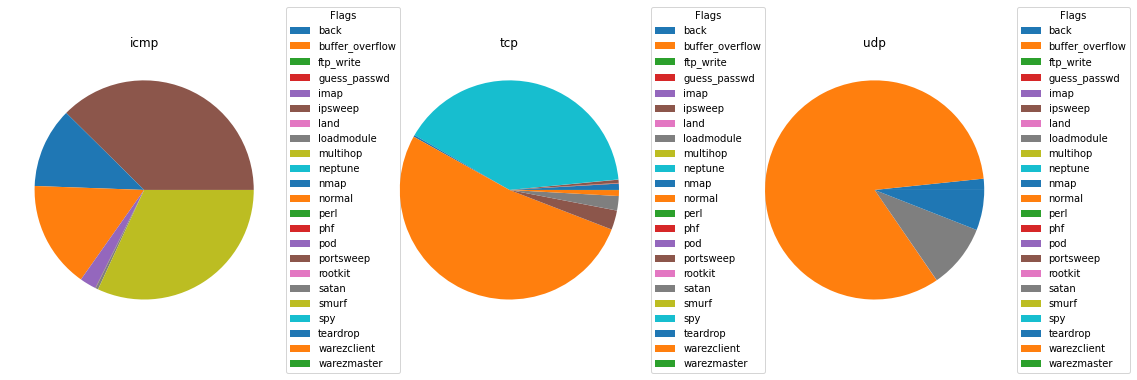

In [18]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

    What we can gather from our analysis is that each protocol type exhibits different patterns in terms of attack prevalence. This leads us to believe that protocol may be a useful feature for identifying the type of traffic being observed. Moving forward, we will investigate if this pattern also holds true for flag.





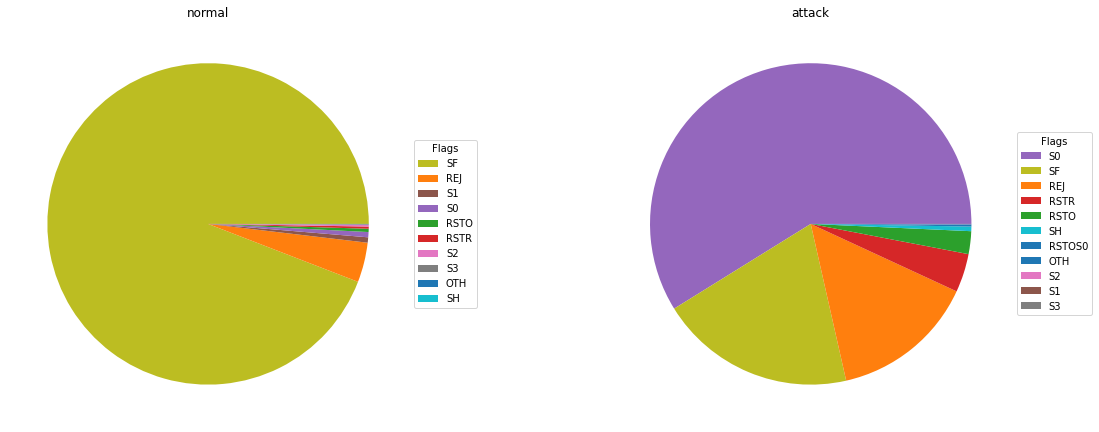

In [20]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()


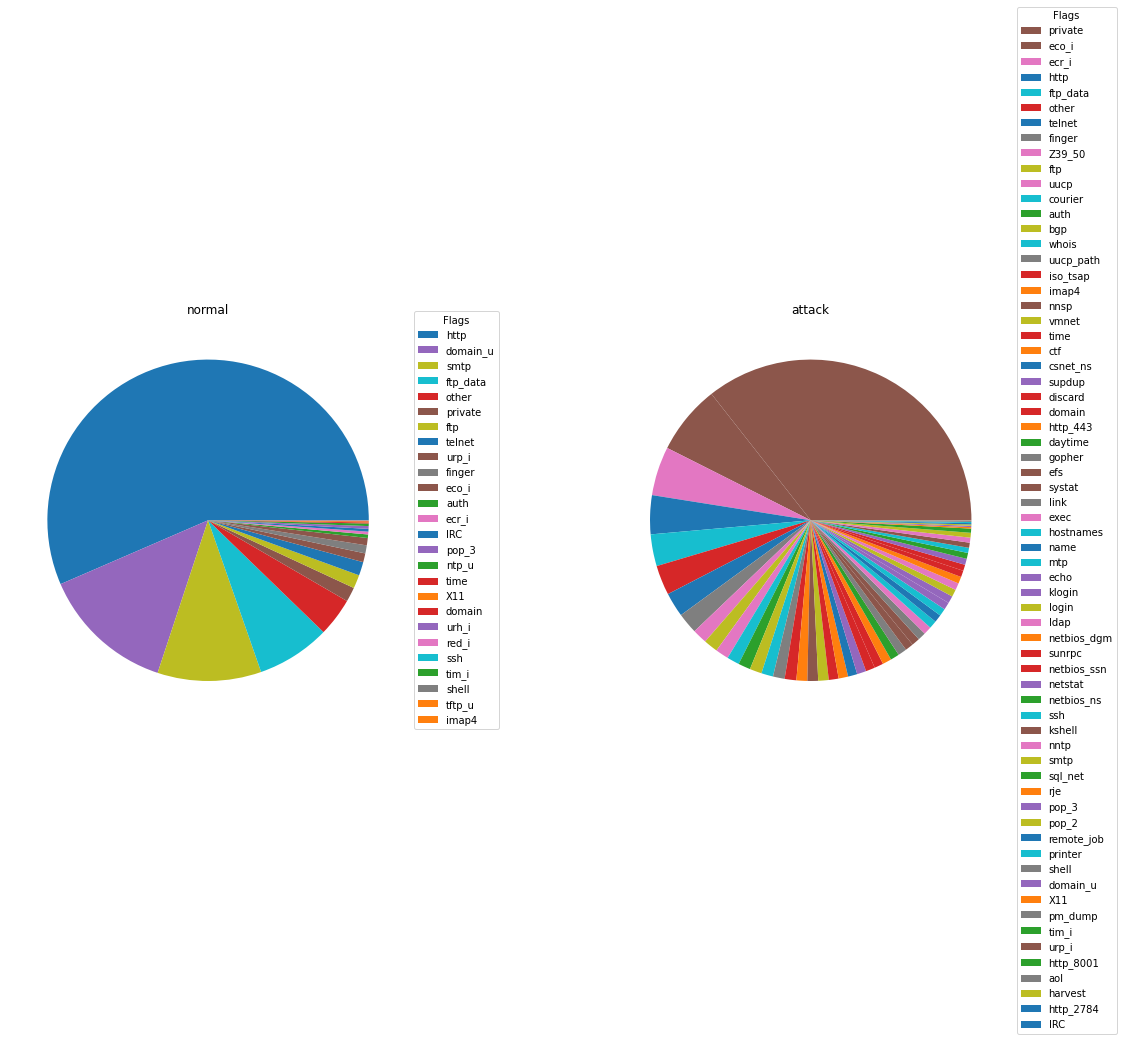

In [21]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
plt.show()

    The observation here is that the attack traffic set contains a large number of services as compared to the normal traffic set which is majorly composed of HTTP. This suggests that the attacks are using different paths to penetrate the systems, some of which are less traveled.

    From a network administrator's perspective, the combination of protocol, flag, and service appears to be a good indicator of the nature of traffic on the network. Additionally, incorporating the duration of connections and the volume of data transmitted could provide a more comprehensive understanding of network traffic.

## Feature engineering:
    The next step is to perform feature engineering by considering the protocol_type, service, and flag as they exhibit significant variations. Moreover, we will include some fundamental numerical data such as duration, source bytes, and destination bytes, which can provide insights into network traffic and are commonly available on modern network equipment.

In [22]:
def get_encoded_features(df, test_df):
    """
    This function encodes the features of a given dataframe and returns them as encoded data frames
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The training data to be encoded
    
    test_df : pandas.DataFrame
        The test data to be encoded
    
    Returns:
    --------
    to_fit : pandas.DataFrame
        The encoded training data
    
    test_set : pandas.DataFrame
        The encoded test data
    
    """
    # get the intial set of encoded features and encode them
    features_to_encode = ['protocol_type', 'service', 'flag']
    encoded = pd.get_dummies(df[features_to_encode])
    test_encoded_base = pd.get_dummies(test_df[features_to_encode])

    # not all of the features are in the test set, so we need to account for diffs
    test_index = np.arange(len(test_df.index))
    column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

    diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

    # we'll also need to reorder the columns to match, so let's get those
    column_order = encoded.columns.to_list()

    # append the new columns
    test_encoded_temp = test_encoded_base.join(diff_df)

    # reorder the columns
    test_final = test_encoded_temp[column_order].fillna(0)

    # get numeric features, we won't worry about encoding these at this point
    numeric_features = ['duration', 'src_bytes', 'dst_bytes']

    # model to fit/test
    to_fit = encoded.join(df[numeric_features])
    test_set = test_final.join(test_df[numeric_features])
    
    return to_fit, test_set


In [23]:
to_fit, test_set = get_encoded_features(df, test_df)


    When working with data, one thing I find helpful is using the pd.get_dummies method. It's a quick way to do one hot encoding on columns, creating a new column for each value with a 0 or 1 indicating whether that column is 'hot'.

    One thing I've noticed is that not every value is in the test data, which can create different shapes in our data frames. To address this, I add some columns, fill them in with zeros, and reorder them to match the original columns. This way, we can be sure that all values are accounted for, even if they're not present in the test data.

In [38]:
from sklearn.model_selection import train_test_split

# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.2)

## Model training and Evaluation:

        In this section, I computed the mean performance metrics for each classifier across cross-validation folds, stored them in a tuple, and appended the results to a list. I also calculated the confusion matrix for each classifier and stored it in a dictionary. Next, I created a summary table of the performance metrics and visualized the accuracy scores using a bar plot. Finally, I displayed the confusion matrices for each classifier using heatmaps.

In [56]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(classifiers, X_train, y_train):
    """
    Compare the performance of a list of classifiers on a binary classification problem.
    
    Args:
    classifiers (list): a list of scikit-learn classifiers to compare
    X_train (numpy array or pandas DataFrame): the training data features
    y_train (numpy array or pandas Series): the training data labels
    
    Returns:
    summary_df (pandas DataFrame): a summary table of the performance metrics for each classifier
    """
    
    # create an empty list to store the performance metrics for each classifier
    results = []
    
    # create an empty dictionary to store the confusion matrices for each classifier
    cm_dict = {}
    
    # loop through each classifier and compute the performance metrics
    for clf in classifiers:
        
        # fit the classifier on the training data
        clf.fit(X_train, y_train)
        
        # compute the cross-validation scores
        scores = cross_validate(clf, X_train, y_train, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=5, n_jobs=-1)
        # compute the mean performance metrics across the cross-validation folds
        accuracy = scores['test_accuracy'].mean()
        precision = scores['test_precision_weighted'].mean()
        recall = scores['test_recall_weighted'].mean()
        f1 = scores['test_f1_weighted'].mean()
        
        # store the performance metrics in a tuple
        result = (clf.__class__.__name__, accuracy, precision, recall, f1)
        results.append(result)
        
        # compute the confusion matrix and store it in the dictionary
        y_pred = clf.predict(X_train)
        cm = confusion_matrix(y_train, y_pred)
        cm_dict[clf.__class__.__name__] = cm
    
    # create a summary table of the performance metrics
    summary_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # plot the performance metrics for each classifier
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=summary_df, x='Classifier', y='Accuracy', color='steelblue', ax=ax)
    ax.set(title='Classifier Performance', xlabel='Classifier', ylabel='Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # display the confusion matrix for each classifier
    for clf_name, cm in cm_dict.items():
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{clf_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    return summary_df


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



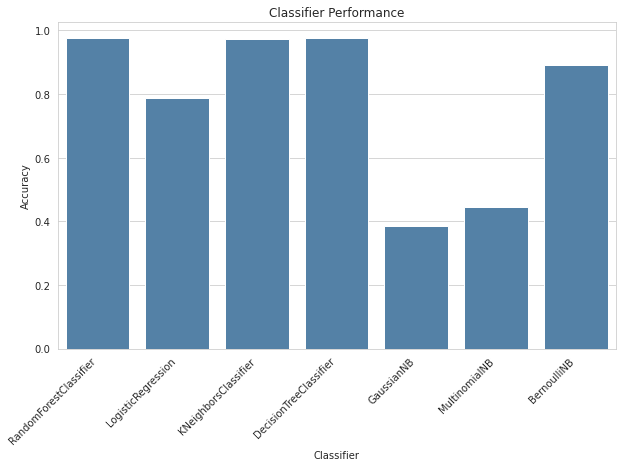

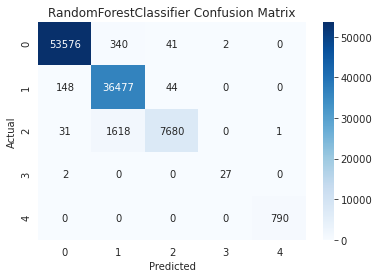

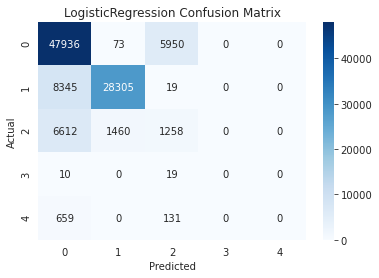

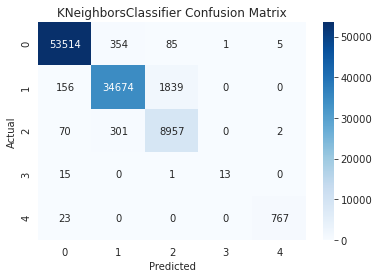

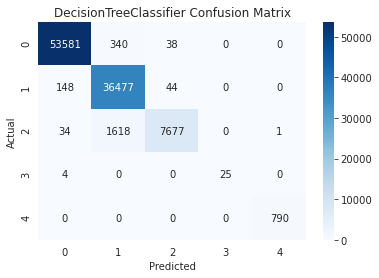

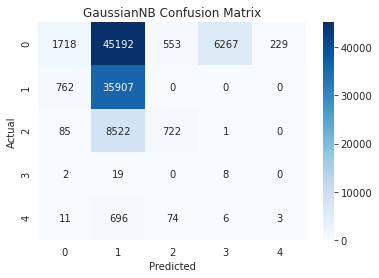

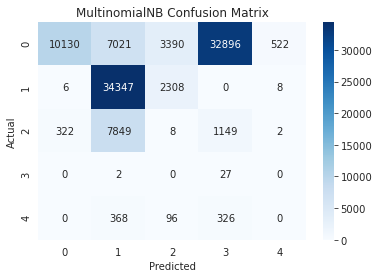

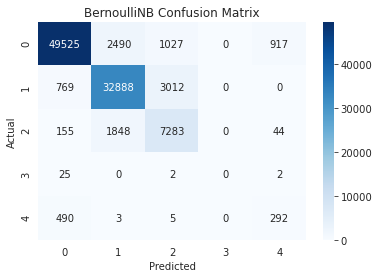

,Classifier,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,0.976542,0.977258,0.976542,0.975901
1,LogisticRegression,0.787204,0.777808,0.787204,0.771578
2,KNeighborsClassifier,0.971918,0.973584,0.971918,0.971988
3,DecisionTreeClassifier,0.976364,0.977093,0.976364,0.975775
4,GaussianNB,0.385475,0.566619,0.385475,0.259521
5,MultinomialNB,0.446282,0.763515,0.446282,0.455304
6,BernoulliNB,0.892833,0.902999,0.892833,0.896735


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB

from sklearn.metrics import confusion_matrix, classification_report

classifiers = [RandomForestClassifier(), LogisticRegression(max_iter=250), KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB(), MultinomialNB(), BernoulliNB()]
compare_models(classifiers, multi_train_X, multi_train_y)



## Database Implementation:

    In this section we implemented a database to store logs and alerts generated by the our model. The database will provide a record of network traffic and any alerts generated, which will be useful for analyzing patterns of suspicious activity.

In [58]:
import sqlite3
import pandas as pd

class NetworkLogsDB:
    def __init__(self, db_name):
        self.conn = sqlite3.connect(db_name)
    
    def create_network_logs_table(self):
        self.conn.execute('''CREATE TABLE IF NOT EXISTS network_logs
                            (id INTEGER PRIMARY KEY,
                            source_ip TEXT NOT NULL,
                            destination_ip TEXT NOT NULL,
                            protocol TEXT NOT NULL,
                            service TEXT NOT NULL,
                            flag TEXT NOT NULL,
                            duration REAL NOT NULL,
                            src_bytes REAL NOT NULL,
                            dst_bytes REAL NOT NULL,
                            predicted_label TEXT NOT NULL);''')

    def create_alerts_table(self):
        self.conn.execute('''CREATE TABLE IF NOT EXISTS alerts
                            (id INTEGER PRIMARY KEY,
                            source_ip TEXT NOT NULL,
                            destination_ip TEXT NOT NULL,
                            alert_type TEXT NOT NULL,
                            alert_message TEXT NOT NULL);''')
    
    def train_and_store_predictions(self, train_X, train_y, val_X, val_y):
        # train the model on the train data
        model = RandomForestClassifier()
        model.fit(train_X, train_y)

        # make predictions on the validation data
        preds = model.predict(val_X)

        # store the predictions and logs in the database
        for i in range(len(val_y)):
            source_ip = val_X.iloc[i, 0]
            destination_ip = val_X.iloc[i, 1]
            protocol = val_X.iloc[i, 2]
            service = val_X.iloc[i, 3]
            flag = val_X.iloc[i, 4]
            duration = val_X.iloc[i, 5]
            src_bytes = val_X.iloc[i, 6]
            dst_bytes = val_X.iloc[i, 7]
            predicted_label = preds[i]

            self.conn.execute('''INSERT INTO network_logs (source_ip, destination_ip, protocol, service, flag, duration, src_bytes, dst_bytes, predicted_label)
                                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                             (source_ip, destination_ip, protocol, service, flag, duration, src_bytes, dst_bytes, predicted_label))

            if preds[i] == val_y.iloc[i]:
                continue
            else:
                self.conn.execute('''INSERT INTO alerts (source_ip, destination_ip, alert_type, alert_message)
                                    VALUES (?, ?, ?, ?)''',
                                 (source_ip, destination_ip, 'anomaly', f'{service} traffic flagged as suspicious'))

        # commit changes
        self.conn.commit()

    def get_network_logs_df(self):
        # read the network_logs table into a pandas dataframe
        network_logs_df = pd.read_sql_query("SELECT * from network_logs", self.conn)
        return network_logs_df
    
    def get_alerts_df(self):
        # read the alerts table into a pandas dataframe
        alerts_df = pd.read_sql_query("SELECT * from alerts", self.conn)
        return alerts_df

    def close_connection(self):
        self.conn.close()


In [59]:

# initialize the database and create the tables
db = NetworkLogsDB('network_logs.db')
db.create_network_logs_table()
db.create_alerts_table()

db.train_and_store_predictions(multi_train_X, multi_train_y, multi_val_X, multi_val_y)
print(db.get_alerts_df())
    



          id source_ip destination_ip alert_type  \
0          1   b'\x00'        b'\x01'    anomaly   
1          2   b'\x00'        b'\x01'    anomaly   
2          3   b'\x00'        b'\x01'    anomaly   
3          4   b'\x00'        b'\x01'    anomaly   
4          5   b'\x00'        b'\x00'    anomaly   
...      ...       ...            ...        ...   
51081  51082   b'\x00'        b'\x01'    anomaly   
51082  51083   b'\x00'        b'\x01'    anomaly   
51083  51084   b'\x00'        b'\x01'    anomaly   
51084  51085   b'\x00'        b'\x01'    anomaly   
51085  51086   b'\x00'        b'\x01'    anomaly   

                         alert_message  
0      0 traffic flagged as suspicious  
1      0 traffic flagged as suspicious  
2      0 traffic flagged as suspicious  
3      0 traffic flagged as suspicious  
4      0 traffic flagged as suspicious  
...                                ...  
51081  0 traffic flagged as suspicious  
51082  0 traffic flagged as suspicious  
51083 